# Predicting Classification of Volume of Comments in Reddit posts

The goals of this notebook are to:
* Convert the text data to a matrix representation
* Build a natural language processing model to predict whether a post will have a number of comments above the median
* Identify the model that will produce the best result possible as measured by the accuracy, precision, and recall scores obtained from the predictions
* Summarize the findings of this analysis and discuss its implications 

#### Import the required libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score

cv = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.stem import WordNetLemmatizer
import nltk
from nltk.stem.porter import *
from nltk.stem import PorterStemmer

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

#### Ingest the cleaned data from the EDA notebook.

In [2]:
df = pd.read_csv('./data/cleaned-data-for-analysis.csv')

In [3]:
df.head(2)

,title,image,video,time_num,num_comments,high_num_comments,question_in_title,competition_key_word,title_polarity,title_subjectivity,holiday,hour_posted,title_len,punc_count,upper_case_pct,subreddit_len,sub_upper_case_pct,subreddit_cnt
0,Twitter permanently suspends Marjorie Taylor G...,0.0,0.0,5.0,4700.0,1,0,0,0.0,0.300000,0,0,70,0,7.142857,4,0.0,49
1,"Ontario Jan 02: 16,714 Cases, 16 Deaths 🏥 ICUs...",0.0,0.0,5.0,605.0,1,0,1,0.0,0.408333,0,0,163,7,28.834356,7,0.0,154


#### Produce a decision tree classifier and plot it to visualize the classification based on the features currently available

In [4]:
X = df.drop(columns=['title','high_num_comments','num_comments'])
y = df['high_num_comments']

In [5]:
dt = DecisionTreeClassifier(random_state=42,max_features=4)

In [6]:
dt.fit(X,y)

DecisionTreeClassifier(max_features=4, random_state=42)

In [7]:
score = cross_val_score(dt,X,y,cv=5)
print("{} Score:\t{:0.2} ± {:0.2}".format("Decision Tree Accuracy", score.mean(), 2 * score.std()))

Decision Tree Accuracy Score:	0.63 ± 0.032


In [8]:
df['high_num_comments'].value_counts(normalize=True)

0    0.501336
1    0.498664
Name: high_num_comments, dtype: float64

The accuracy of the prediction generated by a decision tree classifier outperforms the prediction of the null model, or the expected accuracy of 49.8% for a post having a number of comments that is above the median.

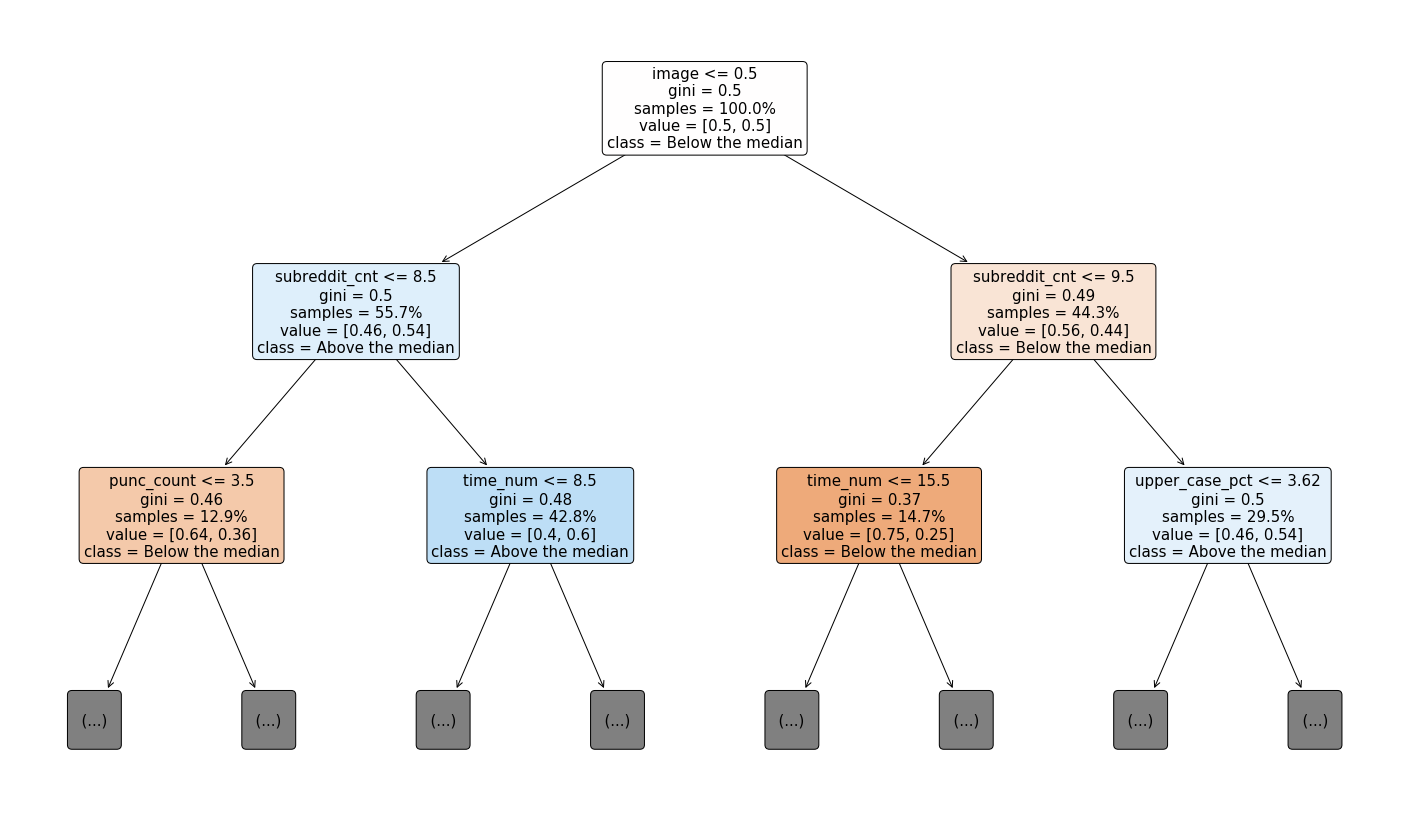

In [9]:
plt.figure(figsize=(25, 15))

plot_tree(dt,filled=True,rounded=True,fontsize=15,feature_names=X.columns,proportion=True,
          class_names=['Below the median','Above the median'],precision=2, max_depth=2);

Based on this plot, the classes with the lowest impurity or where gini statistic is closest to 0 or 1 and farthest from 0.5 is where:
* Posts that have been posted for less than or around 8.5 hours and have less than or around 1 punctuation count have around 70% of the samples belonging to the class of the number of comments below the median.
* The gini statistic is lowest among posts that include less than four words, with 73% of samples belonging to the negative class.
* From this it can be inferred that:
    * More features are necessary to produce better splits of the data and arrive at gini statistics farther away from 0.5.
    * Posts with a low number of words that have been published on Reddit from less than 9 hours and that have less than 1 punctuation count are more or less likely to have a median number of comments below the median.

Use the text data to apply `CountVectorizer` and `TFIDF` to find which words are most associated with a number of comments above the median.

#### Calculate additional features using `CountVectorizer`

This method uses a `bag-of-words` to find the frequency of each term in the Reddit posts. It can highlight the words that are most common in a text but has the downside that it ignores sentence structure and the variation in meaning of some words in texts, which can be captured by a text's polarity and subjectivity.

Use English stop words to remove common words that should not be used to predict the target variable such as `the` or `is`. Use the `strip_accents` parameter to remove accents and normalize characters during the preprocessing step. Limit the number of features returned by the pre-processor to 60 features.

The code for this developing the natural language processing is inspired from the lesson on [nlp](https://git.generalassemb.ly/dsi-andromeda/random-forests/blob/master/independent-practice-solutions.ipynb).

In [10]:
cvec = CountVectorizer(stop_words='english', strip_accents='ascii',max_features=60)
cvec.fit(df['title'])

CountVectorizer(max_features=60, stop_words='english', strip_accents='ascii')

In [11]:
df_cvec = pd.DataFrame(cvec.transform(df['title']).todense(),columns=cvec.get_feature_names())

Display the most frequent words in the data set that are not stopwords.

In [12]:
word_counts = pd.DataFrame(df_cvec.sum(axis=0),columns=['Word count'])
word_counts['Word'] = word_counts.index
word_counts.reset_index(drop=True,inplace=True)
word_counts = word_counts.sort_values('Word count',ascending=False)

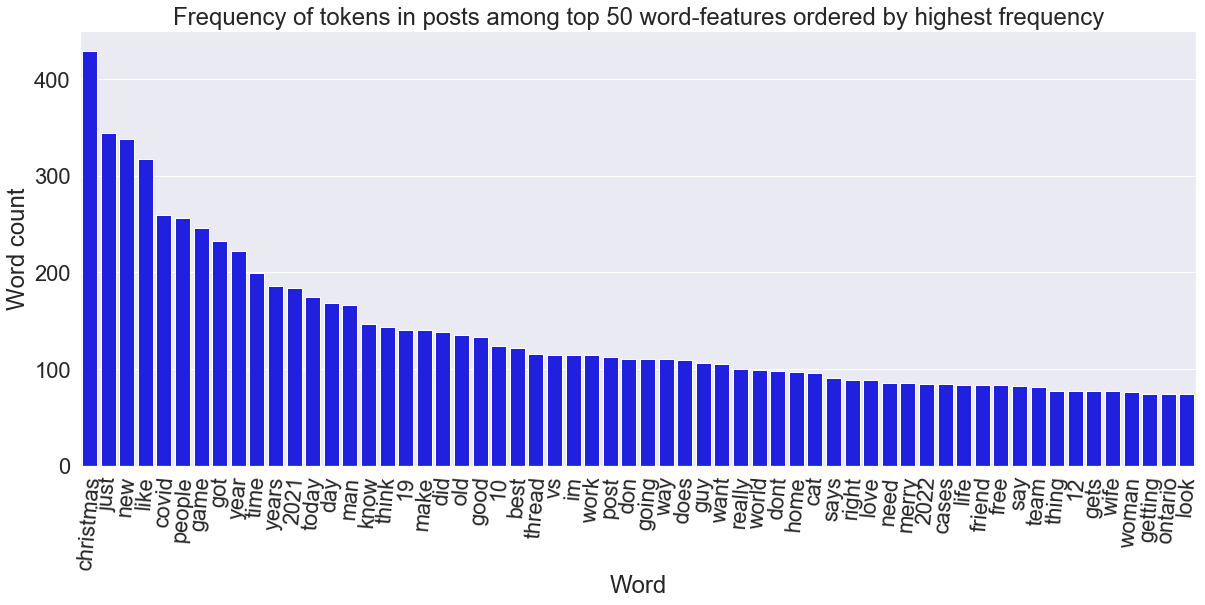

In [13]:
sns.set(font_scale = 2)
plt.figure(figsize=(20,8))
plt.title('Frequency of tokens in posts among top 50 word-features ordered by highest frequency')
plot = sns.barplot(x=word_counts['Word'],y=word_counts['Word count'],color='blue')
plot.set_xticklabels(plot.get_xticklabels(), rotation=85);

From the previous barplot of the number of words most relevant among all posts, it appears that the following words are relevant:
* `christmas`
* `covid` and `cases`
* `year`
* `years`
* `2021`

Since much of the data was collected in December and during the pandemic, the high frequency of these words signals that posts tend to include information that is relevant to current events and the season of the year as expected. It can be hypothesized, then, that posts that reflect current and important events will draw more attention from the Reddit community.

Merge the columns generated using `CountVectorizer` with the columns generated during the EDA stage.

In [14]:
df_cvec = df_cvec.merge(df,how='left', right_index=True,left_index=True)

In [15]:
cols = ['title','num_comments', 'high_num_comments']

In [16]:
X = df_cvec.drop(columns=cols)

In [17]:
y = df_cvec['high_num_comments']

Execute decision-tree, random forest, and KNN classification models to find the most optimal model given the accuracy and precision scores. Run the models using a function to facilitate the process. The code used to calculate the accuracy scores in the function is inspired from the lesson on [ensembles methods](https://git.generalassemb.ly/dsi-andromeda/intro-to-ensembles/blob/master/starter-code-Sophie.ipynb).

The following is the reasoning for using the decision tree, KNN, and random forest models:
* All of these models are non-parametric and therefore do not make assumptions about the distribution of the data
* **KNN**: K-nearest neighbor classifies an observation as belonging to a class depending on the similarity of the features between an observation and its `K` nearest neighbors. The observation will be assigned to the class equal to the majority class in terms of similarity in features between the observations and its `K` nearest neighbors. An advantage of the `KNN` is that it is non-parametric, but a disadvantage is that optimal number of neighbors is not known before modeling. The default number of neighbors is 5.
* **Decision tree**: this model partitions the data based on features used to maximize the purity of the partitions. In other words, it seeks to partition the data based on the model's features in such a way to maximize the percentage of observations belonging to one class. This model has advantages such as performing feature selection, is conceptually clear and does not require standarization of features. However, This type of model is prone to overfitting [source](https://git.generalassemb.ly/dsi-andromeda/trees-CART/blob/master/Introduction%20to%20Classification%20and%20Regression%20Trees%20(CARTs).pdf).
* **Bagging**: Using boostrapping (or sampling with replacement), observations are assigned to multiple combinations of training data sets. The results of the multiple predictions associated with those training data sets are used to select one final prediction through class majority voting [source](https://git.generalassemb.ly/dsi-andromeda/intro-to-ensembles/blob/master/starter-code-Sophie.ipynb).
* **Random forest**: A random forest model uses bootstrapping of observations as in bagging and randomly selected combinations of features to produce the best possible decision tree model based on a combination or class majority of several models for classification problems. This model and the bagging model can help reduce the likelihood of overfitting.
* **Extra-trees model**: This model is similar to the random forest model but instead of using the optimal split for a given feature and samples based on a metric such as the gini measure of impurity, it creates randomly selected thresholds in the features and the most optimal threshold is selected in the splitting rule [source](https://git.generalassemb.ly/dsi-andromeda/random-forests/blob/master/starter-code-Sophie.ipynb).

In [18]:
def classification_models(X, y):    
    dt = DecisionTreeClassifier(class_weight='balanced',random_state=42)
    bdt = BaggingClassifier(DecisionTreeClassifier(),random_state=42)
    rf = RandomForestClassifier(class_weight='balanced', n_estimators=100,n_jobs=-1,random_state=42)
    et = ExtraTreesClassifier(class_weight='balanced',n_jobs=-1,random_state=42)
    knn = KNeighborsClassifier(n_jobs=-1)

    print("Accuracy scores:")

    model = cross_val_score(dt, X, y, cv=cv)
    print("{} Score:\t{:0.2} ± {:0.2}".format("Decision Tree", model.mean(), 2 * model.std()))
    
    model = cross_val_score(bdt, X, y, cv=cv)
    print("{} Score:\t{:0.2} ± {:0.2}".format("Bagging Classifier", model.mean(), 2 * model.std()))
    
    model = cross_val_score(rf, X, y, cv=cv)
    print("{} Score:\t{:0.2} ± {:0.2}".format("Random forest", model.mean(), 2 * model.std()))
    
    model = cross_val_score(et, X, y, cv=cv)
    print("{} Score:\t{:0.2} ± {:0.2}".format("Extra trees", model.mean(), 2 * model.std()))

    model = cross_val_score(knn, X, y, cv=cv)
    print("{} Score:\t{:0.2} ± {:0.2}".format("KNN", model.mean(), 2 * model.std()))
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,stratify=y, random_state=42)
    print(" ")
    print("Precision scores: Decision Tree")
    dt.fit(X_train,y_train)
    preds = dt.predict(X_test)
    print(precision_score(y_test,preds))
    
    print(" ")
    print("Precision scores: Bagging")
    bdt.fit(X_train,y_train)
    preds = bdt.predict(X_test)
    print(precision_score(y_test,preds))
    
    print(" ")
    print("Precision scores: Random forest")
    rf.fit(X_train,y_train)
    preds = rf.predict(X_test)
    print(precision_score(y_test,preds))
    
    print(" ")
    print("Precision scores: Extra trees")
    et.fit(X_train,y_train)
    preds = et.predict(X_test)
    print(precision_score(y_test,preds))
    
    ss = StandardScaler()
    Xs_train = ss.fit_transform(X_train)
    Xs_test = ss.transform(X_test)
    knn.fit(Xs_train,y_train)
    preds = knn.predict(Xs_test)
    print(" ")
    print("Precision scores: KNN")
    print(precision_score(y_test,preds))
    
    return

In [19]:
classification_models(X,y)

Accuracy scores:
Decision Tree Score:	0.64 ± 0.014
Bagging Classifier Score:	0.69 ± 0.016
Random forest Score:	0.72 ± 0.018
Extra trees Score:	0.7 ± 0.017
KNN Score:	0.66 ± 0.0077
 
Precision scores: Decision Tree
0.6248037676609105
 
Precision scores: Bagging
0.7231329690346083
 
Precision scores: Random forest
0.7361809045226131
 
Precision scores: Extra trees
0.7084717607973422
 
Precision scores: KNN
0.6056587091069849


The best model will be the one with the highest accuracy or the ability to predict correctly true positives and true negatives. However, the model that has the highest precision score or the model that identifies the highest percentage of true positives out of all positive predictions is the most relevant to this analysis because the goal is to identify what characteristics of a thread are most predictive of a post with a number of posts above the median. In other words, the focus on this analysis is on correctly predicting the positive class.

With this in mind, from the previous three models, the model that produces the best results is the random forest model, with an accuracy score of approximately 72% and a precision score of approximately 73%.

To visualize the effects of these features, use a logistic regression model to find the effect of the features derived from the `CountVectorizer` transformer on the odds of a post having a number of comments that is above the median. 

In [20]:
def log_reg(X,y):
    lr = LogisticRegression()
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, stratify=y, test_size=.25)
    ss = StandardScaler()
    Xs_train = ss.fit_transform(X_train)
    Xs_test = ss.transform(X_test)
    
    lr.fit(Xs_train,y_train)
    print(lr.score(Xs_train,y_train),lr.score(Xs_test,y_test))
    coeffs = pd.DataFrame(zip(X.columns,lr.coef_.reshape(-1,1)), columns=['Feature', 'Odds ratio'])
    coeffs['Odds ratio'] = coeffs['Odds ratio'].astype(float)
    coeffs = coeffs.sort_values(by='Odds ratio', ascending=False)
    coeffs = coeffs.drop(index=0)
    coeffs['Odds ratio'] = np.exp(coeffs['Odds ratio'])
    return coeffs.sort_values('Odds ratio',ascending=False).head(20)

In [21]:
cvec= log_reg(X,y)

0.6707574557930852 0.666007123070835


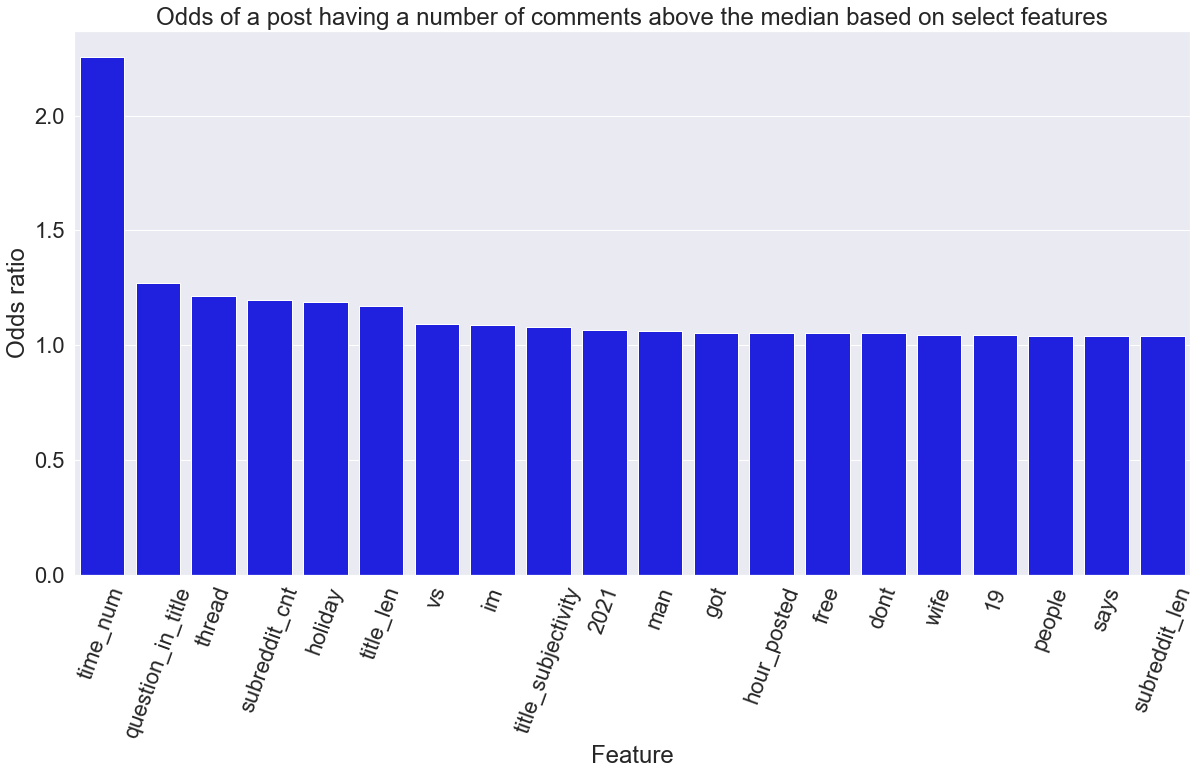

In [22]:
plt.figure(figsize=(20,10))
plt.title('Odds of a post having a number of comments above the median based on select features')
plot = sns.barplot(data=cvec,x='Feature',y='Odds ratio',color='blue')
plot.set_xticklabels(plot.get_xticklabels(), rotation=70);

From this visualization it appears that threads that are posted for a longer amount of time tend to have a higher number of comments, threads that have a question in their title are more likely to have a number of comments above the median than those who don't. Threads that contain the word `thread` tend to have a number of comments above the median. Threads posted during the holiday period of `12-30-2021` to `1-1-2022` are slightly more likely have a number of comments above the median.

#### Use the TfIdf vectorizer to generate word-features from the text data
* An advantage of Tfidf is that a statistical measure of a token's relevance is given within each document such that words that are relevant within a post are given higher weight, but also adjusted (or penalized) if they are very frequent among all posts, giving additional weight to words that are more rare among all posts.
* It is important to convert all word features to their roots, as there are currently in the `CountVectorizer` model features that are variations of the same word such as `year` and `years`. This can be accomplished through a stemming method below.

The code below is inspired from the second lesson on [nlp](https://git.generalassemb.ly/dsi-andromeda/nlp-ii). 

In [23]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

In [24]:
stemmer = PorterStemmer()
df['stemmed_title'] = [' '.join([stemmer.stem(value.text) for value in nlp(text)]) for text in df.title]

In [25]:
tvec = TfidfVectorizer(stop_words='english', max_features = 60, max_df=0.6, norm='l2', strip_accents='ascii')
tvec.fit(df['stemmed_title'])

TfidfVectorizer(max_df=0.6, max_features=60, stop_words='english',
                strip_accents='ascii')

In [26]:
df_tvec = pd.DataFrame(tvec.transform(df['stemmed_title']).todense(),
                      columns=tvec.get_feature_names())

In [27]:
df_tvec = df.merge(df_tvec, left_index=True, right_index=True)

In [28]:
df_tvec.head(3)

,title,image,video,time_num,num_comments,high_num_comments,question_in_title,competition_key_word,title_polarity,title_subjectivity,...,use,ve,vs,wa,want,way,whi,work,world,year
0,Twitter permanently suspends Marjorie Taylor G...,0.0,0.0,5.0,4700.0,1,0,0,0.0,0.300000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,"Ontario Jan 02: 16,714 Cases, 16 Deaths 🏥 ICUs...",0.0,0.0,5.0,605.0,1,0,1,0.0,0.408333,...,0.0,0.0,0.773591,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,What short sentence does every man want to hear?,0.0,0.0,4.0,2700.0,1,1,0,0.0,0.300000,...,0.0,0.0,0.000000,0.0,0.574014,0.0,0.0,0.0,0.0,0.0


In [29]:
cols = ['title','num_comments', 'high_num_comments', 'stemmed_title']

In [30]:
X = df_tvec.drop(columns=cols)
y = df_tvec['high_num_comments']

In [31]:
classification_models(X,y)

Accuracy scores:
Decision Tree Score:	0.64 ± 0.029
Bagging Classifier Score:	0.69 ± 0.019
Random forest Score:	0.72 ± 0.019
Extra trees Score:	0.7 ± 0.021
KNN Score:	0.66 ± 0.004
 
Precision scores: Decision Tree
0.6190476190476191
 
Precision scores: Bagging
0.7240437158469946
 
Precision scores: Random forest
0.7420435510887772
 
Precision scores: Extra trees
0.7060782681099084
 
Precision scores: KNN
0.6001742160278746


Using the stemming methods and the `TfidfVectorizer` results in almost the same accuracy score and a slightly higher accuracy score in the random forest model compared to the `CountVectorizer`. Therefore, of all models built, the random forest model using the `TfidfVectorizer` produces the best results as it has the highest accuracy and precision scores.

This model also outperforms the null model accuracy of 49%.

Visualize the classification performed by the random forest model for two of the 100 estimators in the `n_estimators` parameters of the random forest estimator.

[This](https://mljar.com/blog/visualize-tree-from-random-forest/) resource was helpful in visualizing specific decision trees from the random forest estimators.

In [32]:
select_features = ['image', 'video', 'time_num', 'question_in_title',
       'competition_key_word', 'title_polarity', 'title_subjectivity',
       'holiday', 'hour_posted', 'title_len', 'punc_count', 'upper_case_pct',
       'subreddit_len', 'sub_upper_case_pct', 'subreddit_cnt']

In [33]:
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100,n_jobs=-1,random_state=42)
rf.fit(X[select_features],y)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [34]:
model = cross_val_score(rf, X[select_features], y, cv=cv)
print("{} Score:\t{:0.2} ± {:0.2}".format("Random forest", model.mean(), 2 * model.std()))

Random forest Score:	0.71 ± 0.02


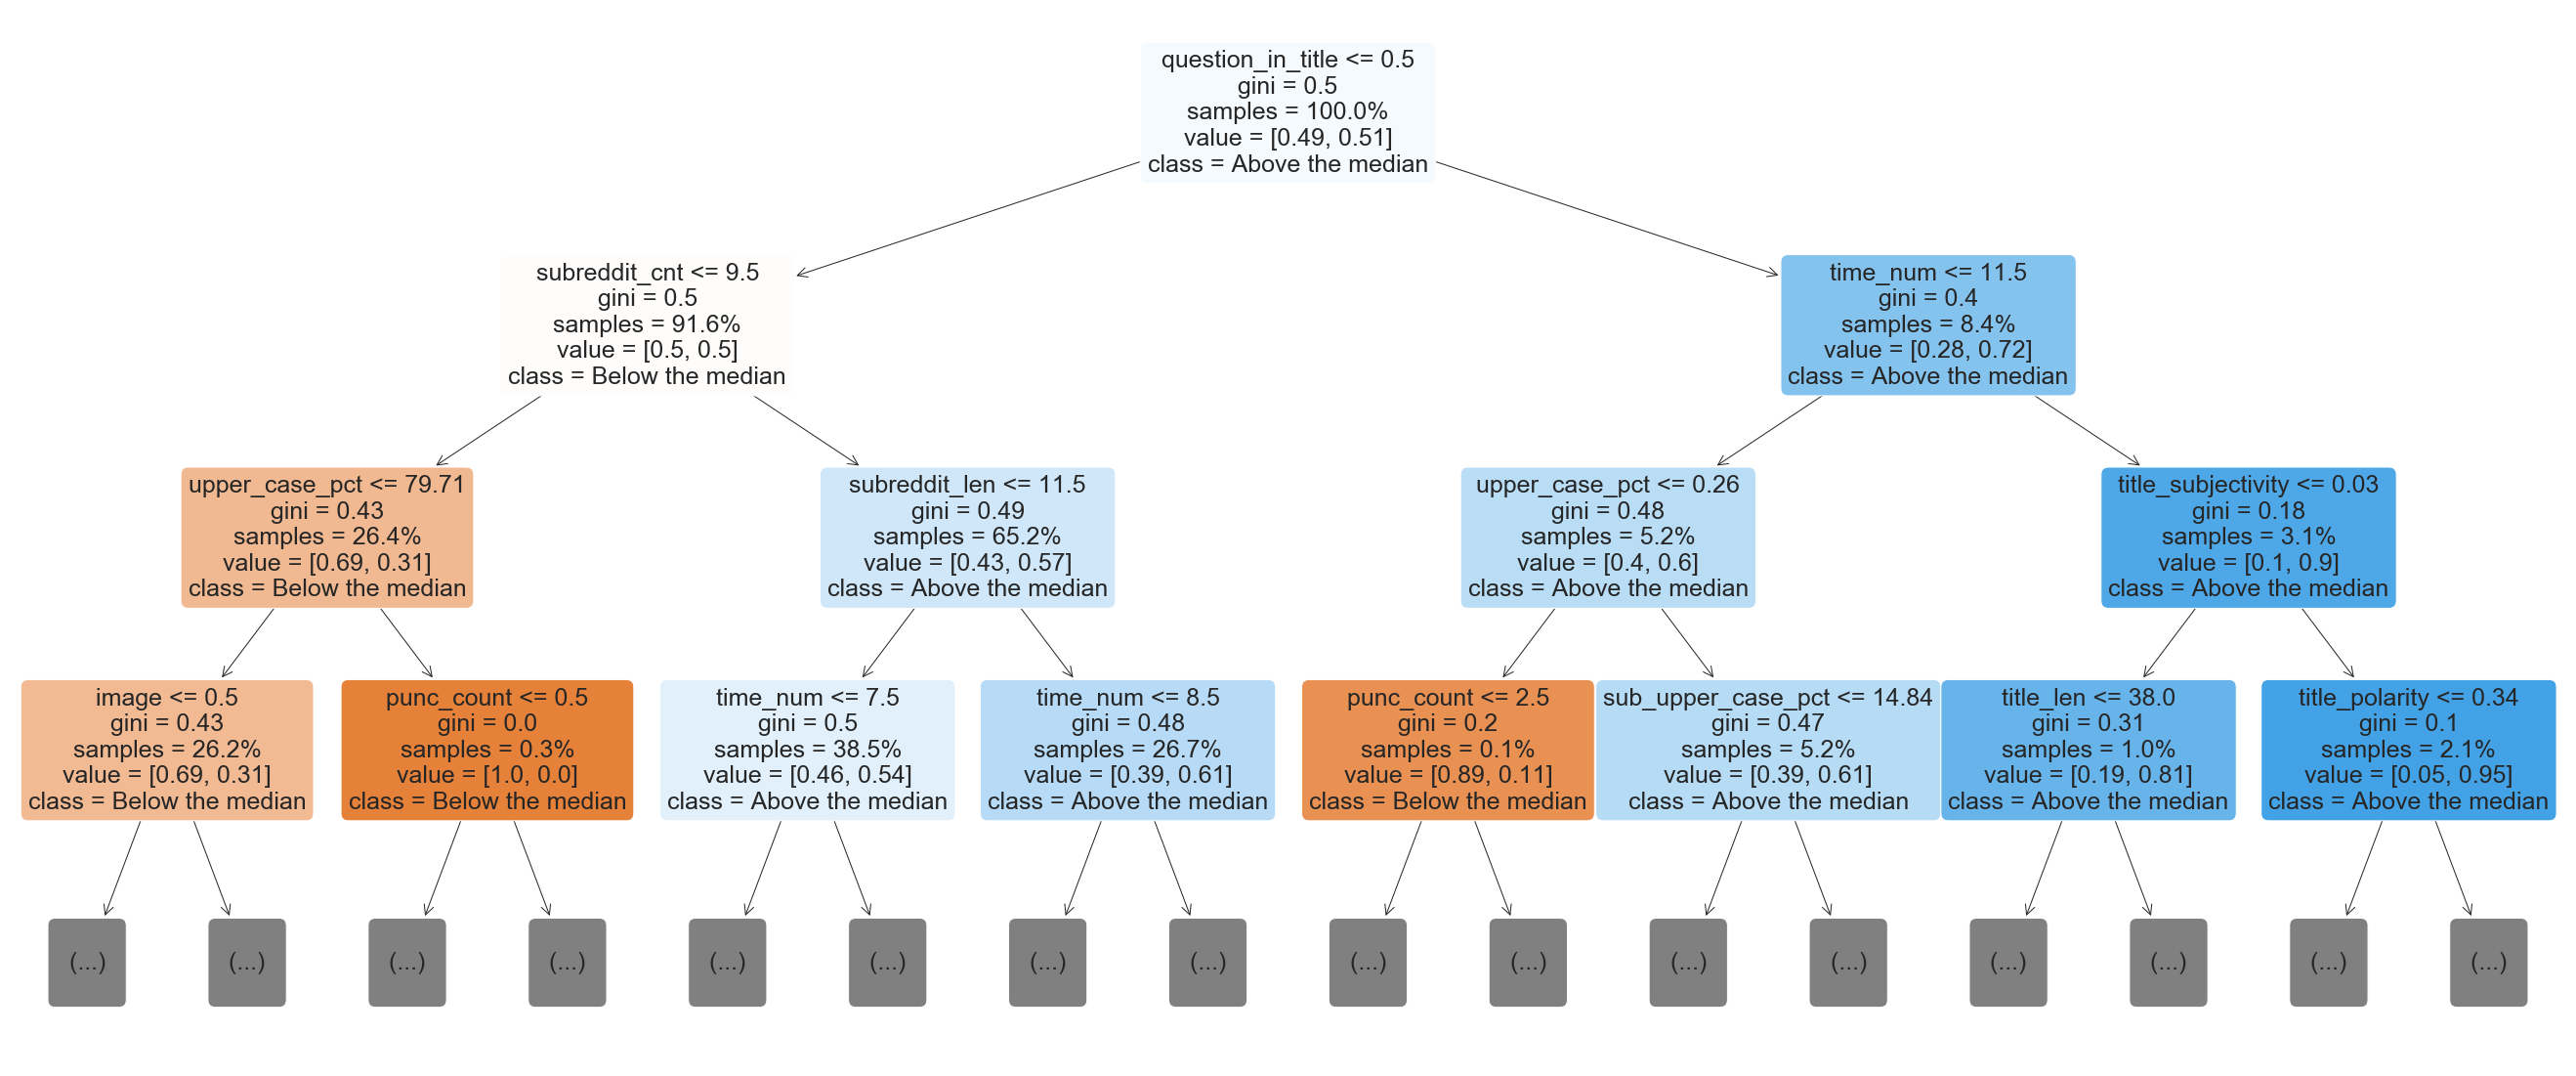

In [35]:
plt.figure(figsize=(47,20))
_ = tree.plot_tree(rf.estimators_[2], feature_names=X[select_features].columns, filled=True, rounded=True,fontsize=25,
              proportion=True,class_names=['Below the median','Above the median'],
              precision=2, max_depth=3)

In one of the decision tree estimators used in the random forest model:
* Threads that had the following characteristics tended to be classified as having a number of comments above the median:
    * For threads that had a question in their title
    * And, had been posted for more than 12 hours, and had a low degree subjectivity and polarity, around 200 (2% of 10,000 threads) of them were classified as having a number of comments above the median

Therefore, whether a post is framed as a question and framed in a neutral tone and a length of characters that isn't too long, may attract more engagement from Reddit users.

Visualize the effect of each feature and the tokens using the `Tfidf Vectorizer` on the odds of a post having a number of comments that is higher than the median using a logistic regression model.

The same analysis as previously produced with the features derived from the `CountVectorizer` are confirmed here with the odds ratios of the logistic regression produced using the features derived from the `Tfidf Vectorizer`.

0.671153338611771 0.6755045508508113


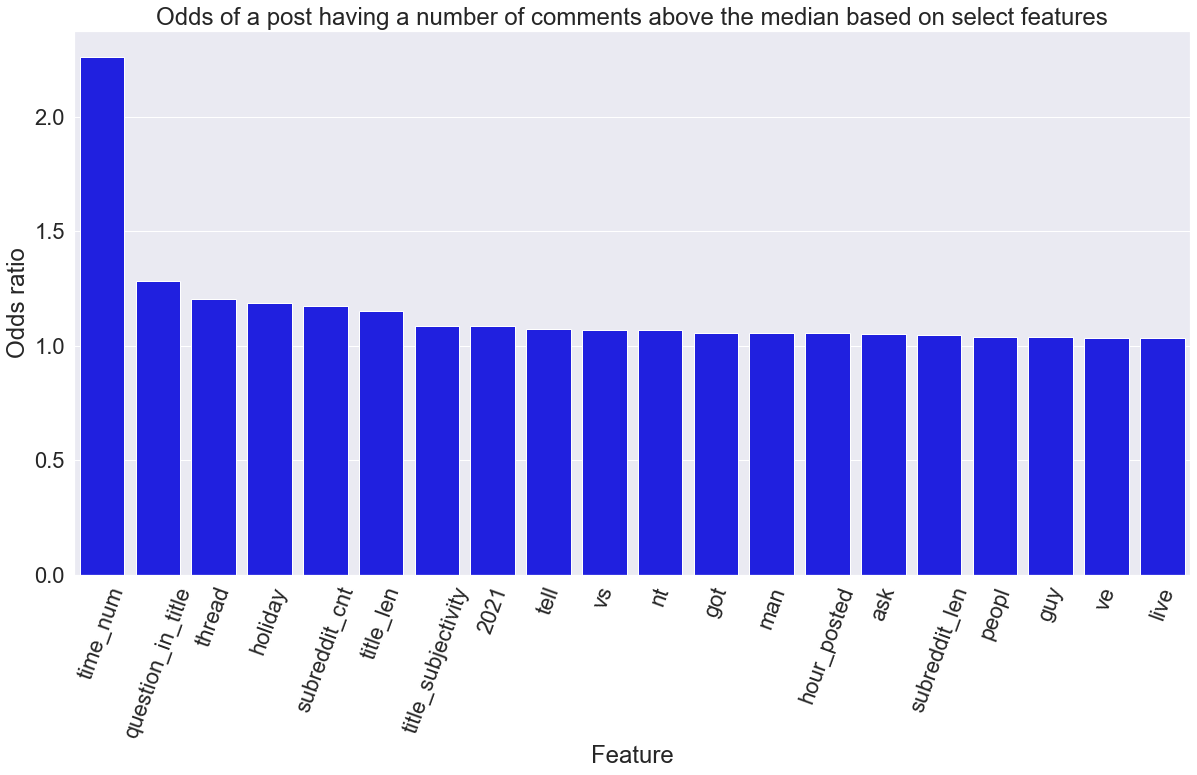

In [36]:
tvec= log_reg(X,y)
plt.figure(figsize=(20,10))
plt.title('Odds of a post having a number of comments above the median based on select features')
plot = sns.barplot(data=tvec,x='Feature',y='Odds ratio',color='blue')
plot.set_xticklabels(plot.get_xticklabels(), rotation=70);

In [37]:
tvec.head(10)

,Feature,Odds ratio
2,time_num,2.259978
3,question_in_title,1.282957
61,thread,1.204044
7,holiday,1.184781
14,subreddit_cnt,1.173910
9,title_len,1.149392
6,title_subjectivity,1.084998
17,2021,1.084716
57,tell,1.073545
67,vs,1.069009


# Executive Summary

The purpose of this analysis was to identify the characteristics of a Reddit post that are predictive of a post having a high level of engagement as measured by having a number of comments above the median. Over 10,000 posts were scrapped from Reddit's home page in December and early January of 2022.

The following characteristics of Reddit posts were hypothesized to be predictive of whether a post has a high level of engagement:
* Whether a thread is framed as a question
* The length of time the post was up on Reddit
* Whether a thread is posted during a holiday
* The number of characters in a post
* The percentage of characters in a post that are upper case letters, among others.

Using a decision tree, bagging, random forest, extra trees, and K-nearest neighbors models, this analysis found that:
* Posts that are framed as a question are 1.3 times more likely that posts that are not framed as a question to have a number of comments above the median
* A longer amount of time the post has been up on Reddit increases the chances of drawing a higher number of comments
* Threads that were posted during the holiday period are 1.2 times more likely to have a number of comments above the median. 
* Tokens such as `thread` the odds of a post having a number of comments above the mean

**Implications**:
* From a marketing perspective, Reddit is a community of individuals who can serve as a testing ground for `wh-` type questions related to a product. For instance, what features would a user like to see in a product, what price would redditors be willing to pay for a product, and more. The marketing office at `FiveThirtyEight` specifically can use Reddit to ask what social issues are of greater concern or importance within the Reddit community to plan for what content to work on in the future.
* In addition, posts that have been up on Reddit for less than 12 hours are classified as having a number of comments above the median. Thereore, marketed content should be up on Reddit for a significant amount of time but the frequency used to refresh the content should be determined.
* Holidays may be days when redditors have more time to be engaged in social media. Therefore, consider posting content during holidays to increase engagement.

To continue this project, it is recommended to analyze further the posts with tokens such as `threads` that are related to a high number of comments to understand their usage among all posts. Focus this analysis on the specific use of tokens and topics among all posts.